# Tytuł Projektu: Analiza cen ofertowych mieszkań w Warszawie

### Projekt ma na celu analizę cen ofertowych mieszkań w Warszawie oraz opracowanie modelu, który pozwoli przewidywać, czy cena ofertowa mieszkania w Warszawie jest przeszacowana w stosunku do mediany cen rynkowych dla danej dzielnicy.




## Zebranie danych

Dane pochodzą z serwisu Otodom.pl i zostały pobrane za pomocą web scraping.

In [2]:
# Importowanie niezbędnych bibliotek
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

In [3]:
# Ustawienia nagłówków dla żądań HTTP
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"}

# Mapowanie nazw pól
fields = {
    'Ogrzewanie': 0,
    'Piętro':1,
    'Czynsz':2,
    'Stan wykończenia':3,
    'Rynek':4,
    'Forma własności':5,
    'Typ ogłoszeniodawcy':7,
    'Rok budowy':9,
    'Winda':10,
    'Rodzaj zabudowy':11
}

# Mapowanie lokalizacji
location = {
    'Województwo':-1,
    'Miejscowość':-2,
    'Dzielnica':-3,
    'Obszar':-4,
    'Ulica':1
}

In [4]:
# Lista, która będzie przechowywać dane o mieszkaniach
data = []

# Pętla do pobierania ofert dla Warszawy z pierwszych dostępnych 20 stron ofert
for i in range(20):
  # Tworzenie dynamicznego URL dla każdej strony wyników
  if i < 1:
    # Pierwsza strona nie ma numeru strony w URL
    in_url = 'https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/mazowieckie/warszawa/warszawa/warszawa?viewType=listing&limit=72'
  else:
    in_url = f'https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/mazowieckie/warszawa/warszawa/warszawa?viewType=listing&limit=72&page={i+1}'

  # Wysyłanie żądania HTTP i parsowanie HTML z wykorzystaniem BeautifulSoup
  response = requests.get(in_url, headers=headers)
  soup = BeautifulSoup(response.content, 'html.parser')

  # Pobieranie linków do poszczególnych ogłoszeń na stronie
  links = soup.find_all('a', attrs={'data-cy': 'listing-item-link'})

  # Pętla do pobrania danych z każdego ogłoszenia na stronie
  for link in links:
      # Tworzenie URL do konkretnego ogłoszenia
      suffix = link.get('href')
      stg_url = f'https://www.otodom.pl{suffix}'
      stg_response = requests.get(stg_url, headers=headers)
      stg_soup = BeautifulSoup(stg_response.content, 'html.parser')

      # Pobranie szczegółowych danych z ogłoszenia
      stg_data = stg_soup.find_all('div', attrs={'class': 'css-t7cajz e15n0fyo1'})

      # Pobieranie danych dotyczących powierzchni oraz liczby pokoi
      attrs['Powierzchnia [m²]'] = float(stg_soup.find_all('div', attrs={'class': 'css-1ftqasz'})[0].get_text().split('m')[0])
      attrs['Liczba Pokoi'] = int(stg_soup.find_all('div', attrs={'class': 'css-1ftqasz'})[1].get_text().split(' ')[0])

      # Pobieranie danych dotyczacych ceny
      try:
        attrs['Cena [PLN]'] = stg_soup.find('div', attrs={'class': 'css-f6whum e1k1vyr20'}).get_text().replace(' ','').replace('zł','')
      except:
        attrs['Cena [PLN]'] = None

      # Pobieranie danych na podstawie mapowania location
      for field_name, index in location.items():
          if index > 0-len(stg_soup.find('div', attrs={'class': 'css-70qvj9 e42rcgs0'}).get_text().split(', ')):
              attrs[field_name] = stg_soup.find('div', attrs={'class': 'css-70qvj9 e42rcgs0'}).get_text().split(', ')[index]
          else:
              attrs[field_name] = None
      # Pobieranie danych na podstawie mapowania fields
      for field_name, index in fields.items():
          if index < len(stg_data):
              attrs[field_name] = stg_data[index].get_text().split(':')[1]
          else:
              attrs[field_name] = None

      # Dodawanie danych dotyczących mieszkania do głównej listy
      data.append(attrs)

  # Dodanie opóźnienia, aby uniknąć blokady IP
  time.sleep(20)

# Tworzenie DataFrame z zebranych danych
data_ = pd.DataFrame(data)

In [7]:
df = data_.copy()
# Podejrzenie ilości zebranych danych
df.shape

(1178, 19)

## Eksploracja Danych

In [21]:
# Wyświetlenie informacji o df, aby zweryfikować typy kolumn, brakujące wartości i ewentualne błędy
df.info()

for i in df.columns:
  print(df[i].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   1178 non-null   object 
 1   Powierzchnia [m²]    1178 non-null   float64
 2   Liczba Pokoi         1178 non-null   int64  
 3   Cena [PLN]           1063 non-null   object 
 4   Województwo          1178 non-null   object 
 5   Miejscowość          1178 non-null   object 
 6   Dzielnica            1178 non-null   object 
 7   Obszar               1015 non-null   object 
 8   Ogrzewanie           1178 non-null   object 
 9   Piętro               1153 non-null   float64
 10  Stan wykończenia     1178 non-null   object 
 11  Rynek                1178 non-null   object 
 12  Forma własności      1178 non-null   object 
 13  Typ ogłoszeniodawcy  1178 non-null   object 
 14  Rok budowy           1178 non-null   object 
 15  Winda                1178 non-null   b

Widzimy, że niektóre kolumny mają nieodpowiedni typ a inne błędy w danych. Przeprowadzę, więc czyszczenie danych.

In [18]:
# Zamiana wartości z kolumny Piętro na wartości numeryczne

def process_value(value):
    if 'parter' in value:
        return 0
    if '/' in value and '>' not in value:
        return int(value.split('/')[0])
    if '>' in value:
        return int(value.split('>')[1].split('/')[0])
    if value == 'brak informacji':
        return None
    else:
        return None
    return int(value)

df['Piętro'] = df['Piętro'].apply(process_value)

# Mapowanie wartości w kolumnie Winda na typ logiczny (True/False) - True -> tak, False -> nie lub brak informacji
df['Winda'] = df['Winda'].map({'tak': True, 'nie': False}).fillna(False)
# Mapowanie wartości w kolumnie Rodzaj zabudowy na: blok, apartamentowiec, kamienica i brak informacji w celu pozbycia się błędnych danych
df['Rodzaj zabudowy'] = df['Rodzaj zabudowy'].map({'blok': 'blok', 'apartamentowiec': 'apartamentowiec', 'kamienica':'kamienica'}).fillna('brak informacji')

<ipython-input-18-edfb1c8e959e>:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Winda'] = df['Winda'].map({'tak': True, 'nie': False}).fillna(False)


Niektóre kolumny, jak Czynsz nie wniosą istotnych informacji do analizy i w przeważającej ilości przykładów zawierają 'brak informacji'. Kolumny te postanawiam usunąć

In [16]:
# Usunięcie kolumn Ulica i Czynsz
df = df.drop('Ulica', axis=1) # Kolumna zawiera te same informację co kolumna Dzielnica
df = df.drop('Czynsz', axis=1) # Większość przykładów zawiera 'brak informacji'

In [23]:
# Konwersja kolumny Cena na typ float

try:
  df['Cena [PLN]'] = df['Cena [PLN]'].astype(float)
except:
  df['Cena [PLN]'] = df['Cena [PLN]'].str.replace(',', '.').astype(float)
  df['Cena [PLN]'] = df['Cena [PLN]']

In [32]:
# Sprawdzenie brakujących wartości
df.isna().sum()

,0
Powierzchnia [m²],0
Liczba Pokoi,0
Cena [PLN],0
Województwo,0
Miejscowość,0
Dzielnica,0
Obszar,0
Ogrzewanie,0
Piętro,0
Stan wykończenia,0


Brakujące wartości występują w kilku kolumnach - Cena, Obszar, Piętro, Cena za m2

In [31]:
# Uzupełnienie brakujących wartości flagą 'Brak informacji dla kolumn: Obszar i Dzielnica oraz średnią dla danej dzielnicy dla kolumny Cena

df['Obszar'] = df['Obszar'].fillna('brak informacji')
df['Dzielnica'] = df['Dzielnica'].fillna('brak informacji')
df['Cena [PLN]'] = df['Cena [PLN]'].fillna(df.groupby('Dzielnica')['Cena [PLN]'].transform('mean'))
df['Cena za m²'] = df['Cena [PLN]'] / df['Powierzchnia [m²]']

# Do uzupełnienia brakujących wartości w kolumnie Cena używam średniej cen dla danej dzielnicy. Jeśli dana dzielnica nie ma uzupełnionej ceny w żadnym przykładzie, wartość ta pozostanie pusta nawet po takim uzupełnieniu wartości.
# W związku z tym dla zabezpieczenia usuwam barkujące wartości
df.dropna(inplace=True)

In [34]:
# Sprawdzenie ilości danych
df.shape

(1151, 17)

In [35]:
# Wyświetlanie statystyk

df.describe(include='all')

,Powierzchnia [m²],Liczba Pokoi,Cena [PLN],Województwo,Miejscowość,Dzielnica,Obszar,Ogrzewanie,Piętro,Stan wykończenia,Rynek,Forma własności,Typ ogłoszeniodawcy,Rok budowy,Winda,Rodzaj zabudowy,Cena za m²
count,1151.000000,1151.000000,1.151000e+03,1151,1151,1151,1151,1151,1151.000000,1151,1151,1151,1151,1151,1151,1151,1151.000000
unique,NaN,NaN,NaN,1,4,21,114,6,NaN,4,2,4,3,111,2,4,NaN
top,NaN,NaN,NaN,mazowieckie,Warszawa,Mokotów,brak informacji,miejskie,NaN,do zamieszkania,wtórny,pełna własność,biuro nieruchomości,2025,True,blok,NaN
freq,NaN,NaN,NaN,1151,1144,151,155,740,NaN,621,879,903,814,108,794,471,NaN
mean,60.632094,2.618593,1.141614e+06,NaN,NaN,NaN,NaN,NaN,3.097307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18656.161412
std,29.399885,1.000679,8.775180e+05,NaN,NaN,NaN,NaN,NaN,2.705084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6258.263358
min,11.700000,1.000000,2.300000e+05,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7672.993593
25%,41.500000,2.000000,7.024995e+05,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14551.797040
50%,54.260000,3.000000,8.880000e+05,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17468.387433
75%,70.000000,3.000000,1.249247e+06,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21293.084443


W celu określenia klasy dla danych treningowych posłużono się raportem dostępnym pod adresem - [link](https://podkluczyk.pl/ceny-mieszkan-w-warszawie-w-lutym-2024-wedlug-dzielnic/)
zawierającym informacje dotyczące mediany cen ofertowych mieszkań w Warszawie z lutego 2024 roku w podziale na dzielnice. Ceny te zostały skorygowane o 20% w celu osiągnięcia szacowanych median cen transakcyjnych. Zgodnie z artykułem ([link](https://www.bankier.pl/wiadomosc/Ceny-mieszkan-a-oczekiwania-sprzedajacych-nizszy-popyt-zaczal-zmniejszac-roznice-8805329.html)) różnice między cenami ofertowymi a transakcyjnymi w Warszawie w 2024 wynosiły 23.5%.

In [36]:
# Mediany cen ofertowych mieszkań w Warszawie z lutego 2024 według dzielnic - źródło: https://podkluczyk.pl/ceny-mieszkan-w-warszawie-w-lutym-2024-wedlug-dzielnic/
# Cena za m2


ceny_mieszkan = {
    "Śródmieście": 23000,
    "Żoliborz": 21600,
    "Wilanów": 20600,
    "Wola": 20000,
    "Mokotów": 19200,
    "Ochota": 18000,
    "Praga-Południe": 17200,
    "Włochy": 16900,
    "Praga-Północ": 16800,
    "Bielany": 16800,
    "Ursynów": 16700,
    "Bemowo": 16400,
    "Targówek": 14800,
    "Ursus": 14600,
    "Wawer": 13400,
    "Rembertów": 13400,
    "Białołęka": 13300,
    "Wesoła": 11800
}

# Korekta median cen
for d,c in ceny_mieszkan.items():
  ceny_mieszkan[d] = c * 0.80

ceny_mieszkan

{'Śródmieście': 18400.0,
 'Żoliborz': 17280.0,
 'Wilanów': 16480.0,
 'Wola': 16000.0,
 'Mokotów': 15360.0,
 'Ochota': 14400.0,
 'Praga-Południe': 13760.0,
 'Włochy': 13520.0,
 'Praga-Północ': 13440.0,
 'Bielany': 13440.0,
 'Ursynów': 13360.0,
 'Bemowo': 13120.0,
 'Targówek': 11840.0,
 'Ursus': 11680.0,
 'Wawer': 10720.0,
 'Rembertów': 10720.0,
 'Białołęka': 10640.0,
 'Wesoła': 9440.0}

In [48]:
# Mapowanie median cen do dzielnic
df['Mediana za m²'] = df['Dzielnica'].map(ceny_mieszkan)

# Obliczenie etykiet
def przypisz_etykiete(row):
    if row['Cena za m²'] > row['Mediana za m²'] * 1.2:
        return 'Przeszacowana'
    elif row['Cena za m²'] < row['Mediana za m²'] * 0.8:
        return 'Okazja'
    else:
        return 'Adekwatna'

df['Etykieta'] = df.apply(przypisz_etykiete, axis=1)

In [63]:
df['Etykieta'].value_counts()

,count
Etykieta,
Przeszacowana,663
Adekwatna,463
Okazja,25


In [50]:
# Usunięcie kolumy Mediana za m² - kolumna ta służyła wyłącznie do obliczenia etykiet

df = df.drop('Mediana za m²', axis=1)

Podsumowanie fazy EDA:

- Zbiór danych składa się z 1151 mieszkań opisanych przez 17 atrybutów i jeden atrybut decyzyjny zawierający etykiety: Przeszacowana, Okazja, Adekwatna.

- Opis Klas:
  - Przeszacowana - cena mieszkania jest o 20% wyższa niż skorygowana mediana cen dla dzielnicy w 2024 roku
  - Okazja - cena mieszkania jest o 20% niższa niż skorygowana mediana cen dla dzielnicy w 2024 rok
  - Adekwatna - cena mieszkania mieści się w granicach +/- 20% od skorygowanej mediany cen dla dzielnicy w 2024 roku.
  


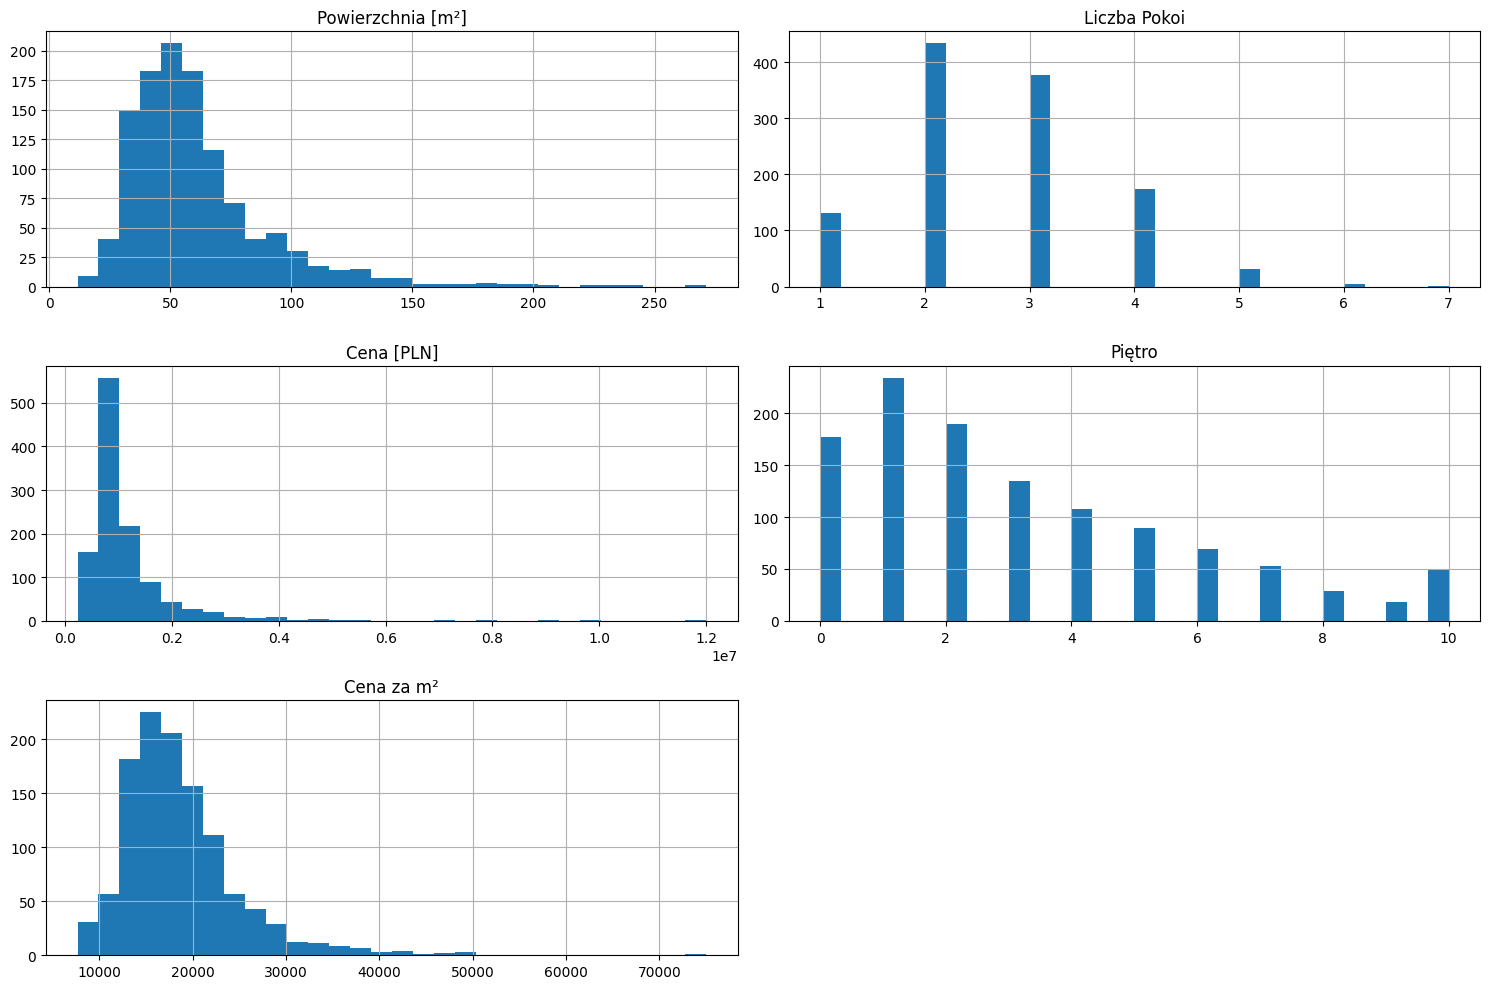

In [46]:
# Histogramy dla zmiennych numerycznych
import matplotlib.pyplot as plt

df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

Analiza Histogramów:

- Powierzchnia [m²]: Rozkład ma prawoskośny charakter – większość mieszkań ma powierzchnię do 50 m², a tylko niewielka część przekracza 100 m².

- Cena [PLN]: Podobnie jak powierzchnia, ceny są skoncentrowane w niższym zakresie z nielicznymi przypadkami bardzo wysokich wartości.

- Cena za m²: Rozkład wskazuje, że większość ofert mieści się w przedziale 10 000-20 000 PLN/m².
- Liczba pokoi: Widać, że najczęściej występują mieszkania 2- i 3-pokojowe.

- Piętro: Rozkład pięter sugeruje, że największą część mieszkań stanowią lokale na niskich piętrach.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Podział danych na cechy (X) i etykiety (y)
X = df.drop(columns=['Etykieta'])
y = df['Etykieta']

# Przekształcenie etykiet na wartości numeryczne za pomocą LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Kodowanie zmiennych na kategorie binarne za pomocą one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Podział danych na zbiór treningowy i testowy (80% trening, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelowanie

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [58]:
# Definiowanie modelu
dt = DecisionTreeClassifier(random_state=42)

# Definiowanie parametrów do przeszukania
param_grid = {
    'max_depth': [5, 10, 15, 20], # Maksymalna głębokość drzewa
    'min_samples_split': [2, 5, 10], # Minimalna liczba próbek do podziału węzła
    'min_samples_leaf': [1, 2, 4] # Minimalna liczba próbek w liściu
}


In [59]:
# GridSearchCV dla optymalizacji hiperparametrów
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

# Najlepsze parametry i wynik
print("Najlepsze parametry dla Drzewa Decyzyjnego: ", grid_search_dt.best_params_)
print("Najlepszy wynik: ", grid_search_dt.best_score_)

Najlepsze parametry dla Drzewa Decyzyjnego:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Najlepszy wynik:  0.933695652173913


In [60]:
# Użycie najlepszego modelu z GridSearchCV do przewidywań na zbiorze testowym
best_dt = grid_search_dt.best_estimator_
y_pred = best_dt.predict(X_test)

# Raport klasyfikacji i dokładność na danych testowych
print("\nRaport klasyfikacji na danych testowych: ")
print(classification_report(y_test, y_pred))

print("Dokładność: ", accuracy_score(y_test, y_pred))


Raport klasyfikacji na danych testowych: 
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        84
           1       0.80      0.57      0.67         7
           2       0.96      0.96      0.96       140

    accuracy                           0.94       231
   macro avg       0.89      0.82      0.85       231
weighted avg       0.94      0.94      0.94       231

Dokładność:  0.9393939393939394


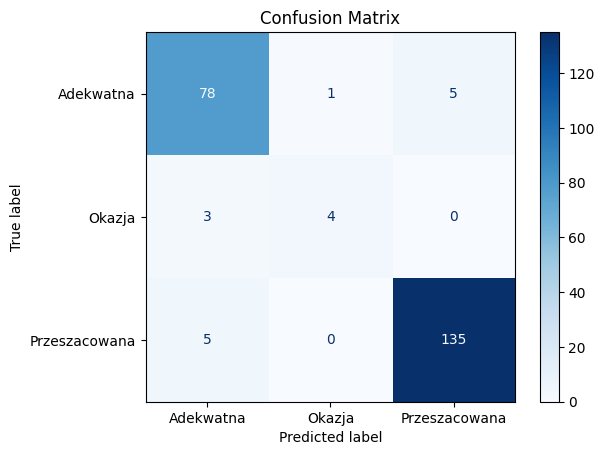

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)

# Wizualizacja macierzy pomyłek
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


Analiza wyników:
- Model bardzo dobrze radzi sobie z klasyfikowaniem klasy "Przeszacowana" - wysoka precyzja (96%), czułość (96%) i f-score (96%)

- Klasa "Adekwatna" również jest dobrze klasyfikowana, chociaż nieco gorzej niż klasa "Przeszacowana"

- Model ma problemy z klasyfikowaniem klasy "Okazja" - niska czułość i f-score dla tej klasy, ale klasa ta miała najmniej przykładów w zbiorze.

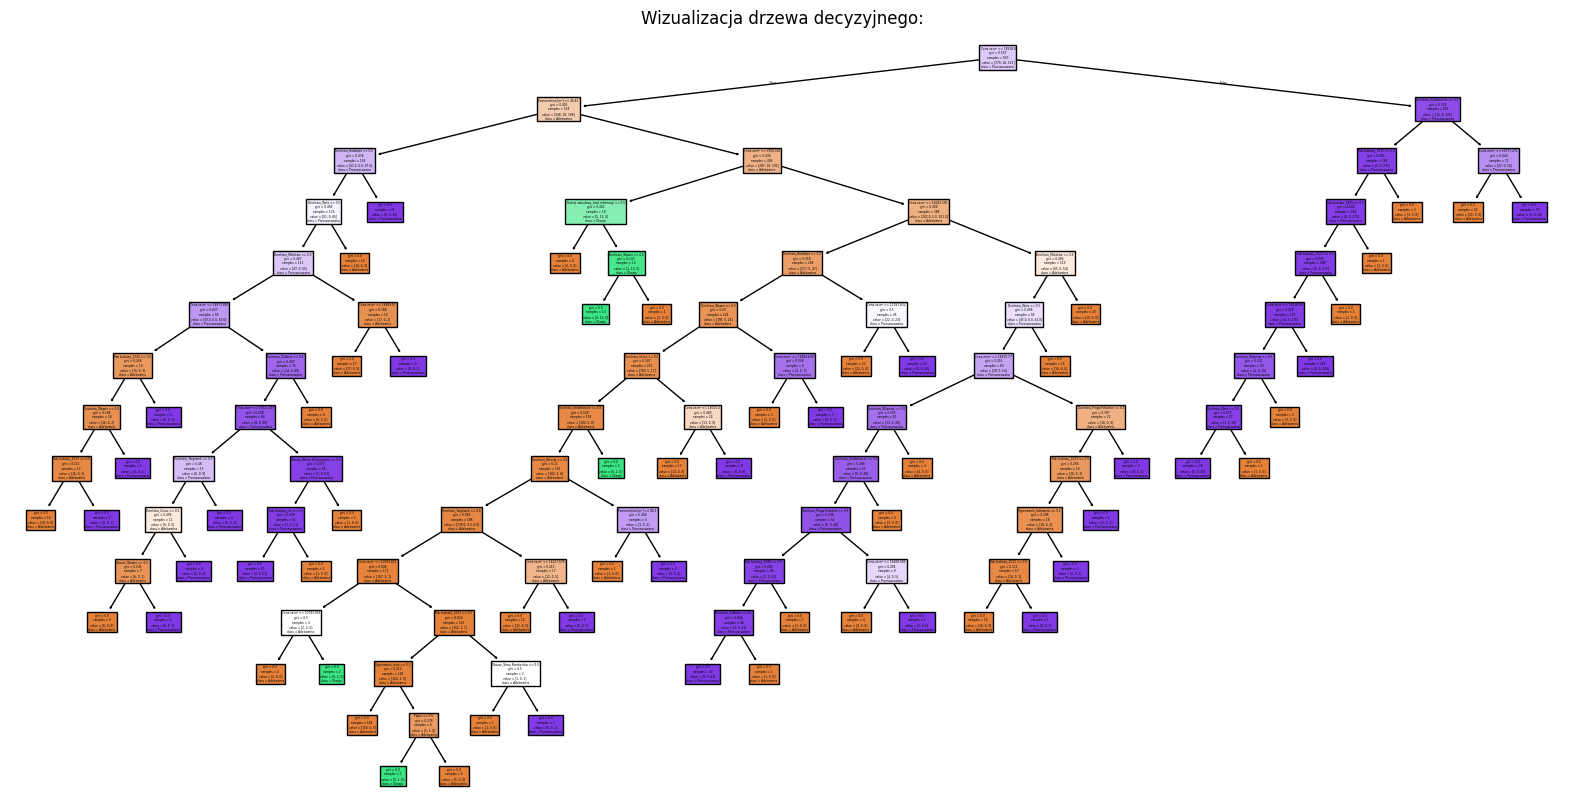


Reguły Drzewa Decyzyjnego:

|--- Cena za m² <= 18918.90
|   |--- Powierzchnia [m²] <= 46.81
|   |   |--- Dzielnica_Białołęka <= 0.50
|   |   |   |--- Dzielnica_Wola <= 0.50
|   |   |   |   |--- Dzielnica_Mokotów <= 0.50
|   |   |   |   |   |--- Cena za m² <= 14973.88
|   |   |   |   |   |   |--- Rok budowy_2020 <= 0.50
|   |   |   |   |   |   |   |--- Dzielnica_Wawer <= 0.50
|   |   |   |   |   |   |   |   |--- Rok budowy_1972 <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- Rok budowy_1972 >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- Dzielnica_Wawer >  0.50
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- Rok budowy_2020 >  0.50
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- Cena za m² >  14973.88
|   |   |   |   |   |   |--- Dzielnica_Żoliborz <= 0.50
|   |   |   |   |   |   |   |--- Cena za m² <= 15921.33
|   |   |   |   |   |   |   |   |--- Dzie

In [62]:
# Wizualizacja Drzewa Decyzyjnego
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=X.columns, class_names=label_encoder.classes_, filled=True)
plt.title("Wizualizacja drzewa decyzyjnego: ")
plt.show()

# Eksport w formie tekstowej
tree_rules = export_text(best_dt, feature_names=list(X.columns))
print("\nReguły Drzewa Decyzyjnego:\n")
print(tree_rules)